In [1]:
from IPython import get_ipython
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
import sys
sys.path.insert(0, '/nas/xd/projects/transformers/src/transformers')
import os
device_mappings = {0: 1, 1: 5, 2: 6, 3: 7, 4: 2, 5: 3, 6: 0, 1: 4}
os.environ["CUDA_VISIBLE_DEVICES"] = str(device_mappings[2])

import random
import string
from collections import defaultdict, OrderedDict
from itertools import product, chain
import math
import numpy as np
from pattern.en import comparative

import matplotlib.pyplot as plt
import seaborn as sns

from captum.attr import IntegratedGradients, LayerConductance, LayerIntegratedGradients
from captum.attr import configure_interpretable_embedding_layer, remove_interpretable_embedding_layer

In [3]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss, MSELoss
from torch.utils.data.dataset import Dataset, IterableDataset
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.sampler import RandomSampler, Sampler, SequentialSampler
from enum import Enum
from typing import List, Optional, Union

from child_frames import frames
from utils import *

import logging
import os
import sys

from transformers import HfArgumentParser, Trainer, TrainingArguments, set_seed
from transformers import AutoConfig, PreTrainedModel, RobertaForMaskedLM, RobertaTokenizer
from transformers.modeling_roberta import RobertaForProbing, RobertaDoubleHeadsModel, \
    RobertaDoubleHeadsModel2, RobertaDoubleHeadsModel3, RobertaForSequenceClassification  # XD
from transformers.trainer import get_mean_pred_prob  # XD
from transformers.data.data_collator import DataCollator, default_data_collator
from transformers import T5Tokenizer, T5ForConditionalGeneration

logging.basicConfig(level=logging.ERROR)

TRANSFORMERS_CACHE = /home/xd/.cache/torch/transformers


In [4]:
A_template = "{rel_prefix} {dt} {ent0} {rel} {dt} {ent1}"
B_template = "{pred_prefix} {dt} {ent} {pred}"
entailment_templates = ["{A} , so {B} ? {conj} .", '"{A}" {conj} "{B}" .', "{A} .||| {B} .|||{conj}", "{A}? {conj}, {B}."]

_tag2id = {'same': 0, 'opposite': 1, 'unrelated': 2, 'former': 0, 'latter': 1, 'another': 5, 'single': 6, 'paired': 7}
tag2id = {'Ġ' + k: v for k, v in _tag2id.items()}
id2tag = {v: k for k, v in tag2id.items()}

markers = {'lexical': '*', 'entity': '#'}
ans2verb = {'Right': 'means', 'Wrong': 'contradicts', 'Maybe': ','}
ans2adj = {'Right': 'clear', 'Wrong': 'unlikely', 'Maybe': 'possible'}
ans2label = {'Right': 'e', 'Wrong': 'c', 'Maybe': 'n'}
ans2yesno = {'Right': 'Yes', 'Wrong': 'No', 'Maybe': 'Maybe'}

def convert_conj(conj): return ans2verb[conj]
def extract_rel_id(s): return int(s[s.index(':') + 1])
def extract_rel(s): return [t.split(':')[0] for t in s.split() if ':' in t][0]
def strip_rel_id(s, lexical_rel=''):
    rel_id_span = s[s.index(':'): s.index(':') + 2]
    if lexical_rel != '': lexical_rel = ' ( ' + lexical_rel + ' )'
    return s.replace(rel_id_span, lexical_rel)
        
relation_labels = {'entity': ['former', 'latter'], 'lexical': ['same', 'opposite', 'unrelated']}

def make_sentences(entities=['_X', '_Z'], entity_set=string.ascii_uppercase, determiner="",
                   relation_group=[['large'], ['small']], rand_relation_group=[["short"], ["tall", "high"]],
                   relation_prefix="", relation_suffix="", predicate_prefix="",
                   n_entity_trials=3, has_negA=True, has_negB=True, has_neutral=False, mask_types={'sent_rel'}, 
                   lexical_relations=None, entity_relations=None, tag_lexical_rel=False, tag_entity_rel=False, sample_ratio=None):
#     if tag_lexical_rel: mask_types.add('lexical_rel')
#     if tag_entity_rel: mask_types.add('entity_rel')
    def get_comparative(word):
        compar = comparative(word)
        if tag_lexical_rel:
            marker = markers['lexical']
            compar = compar.replace('more ', 'more %s ' % marker) if compar.startswith('more ') else marker + ' ' + compar
        return compar
  
    def form_As(relations):
        return [A_template.format(dt=determiner, ent0=ent0, ent1=ent1, rel=rel, rel_prefix=relation_prefix)
              for ent0, ent1, rel in [entities + relations[:1], reverse(entities) + reverse(relations)[:1]]]
    As = []
    for rel0 in relation_group[0]:
        for rel1 in relation_group[1]:
            relations = ["is %s:%d than" % (get_comparative(rel), i) for i, rel in enumerate([rel0, rel1])]
            As += form_As(relations)
    As = list(set(As))
    negAs = join_lists([negate_sent(A)[:1] for A in As]) if has_negA else []

    def form_Bs(predicates): 
        f = mask if 'entity' in mask_types else (lambda x: x)
        return [B_template.format(dt=determiner, ent=f(ent), pred=pred, pred_prefix=predicate_prefix)
              for ent, pred in zip(entities, predicates)]

    Bs, negBs = {'orig': [], 'rand': []}, {}
    for k, group in zip(['orig', 'rand'], [relation_group, rand_relation_group]):
        for rel0 in group[0]:
            for rel1 in group[1]:
                predicates = ["is %s:%d" % (get_comparative(rel), i) for i, rel in enumerate([rel0, rel1])]
                Bs[k] += form_Bs(predicates)
    for k in Bs:
        Bs[k] = list(set(Bs[k]))
        if has_negB:
            negBs[k] = join_lists([negate_sent(B)[:1] for B in Bs[k]])
            Bs[k], negBs[k] = Bs[k] + [swap_entities(negB) for negB in negBs[k]], negBs[k] + [swap_entities(B) for B in Bs[k]]
        else:
            negBs[k] = [swap_entities(B) for B in Bs[k]]
      
    comparatives = [comparative(r).replace('more ', '') for r in join_lists(relation_group) + join_lists(rand_relation_group)]
    def form_sentences(sentence_template, As, Bs, conj):
        def compare_and_tag_comparative(A, B):
            if 'Maybe' in conj:
                lexical_rel = 'unrelated'
            else:
                lexical_rel = 'same' if extract_rel_id(A) == extract_rel_id(B) else 'opposite'
            if lexical_relations and lexical_rel not in lexical_relations:
                return None, None
            if 'lexical_rel' in mask_types: lexical_rel = mask(lexical_rel)
            return strip_rel_id(A), strip_rel_id(B, lexical_rel) if tag_lexical_rel else strip_rel_id(B)
        def tag_entity(token, recurred_entity, entity_rel=None):
            if token != recurred_entity: return token
            return markers['entity'] + ' ' + token
#             if token not in entities: return token
#             entity_rel = 'paired' if token == recurred_entity else 'single'
#             if 'entity_rel' in mask_types: entity_rel = mask(entity_rel)
#             return token + ' ( %s )' % entity_rel
        def compare_and_tag_entity(A, B):
            recurred_entity = [e for e in entities if e in B.split()][0]
            if tag_entity_rel:
                A = ' '.join([tag_entity(token, recurred_entity) for token in A.split()])
                B = ' '.join([tag_entity(token, recurred_entity) for token in B.split()])
            entity_rel = 'former' if A.split().index(recurred_entity) in [0, 1] else 'latter'
            if entity_relations and entity_rel not in entity_relations: return None, None
            if 'entity_rel' in mask_types: entity_rel = mask(entity_rel)
            if tag_entity_rel: B = B.replace(recurred_entity, recurred_entity + ' ( ' + entity_rel + ' )')
            return A, B
        
        if '?' not in sentence_template:
            conj = ans2label[conj] if sentence_template.count('|||') == 2 else ans2verb[conj]
        conj = ans2yesno[conj]
        if 'sent_rel' in mask_types and conj not in ans2label.values(): conj = mask(conj)
        sentences = []
        cores = []
        for A, B in product(As, Bs):
            A, B = compare_and_tag_comparative(A, B) \
                if tag_lexical_rel or lexical_relations else (strip_rel_id(A), strip_rel_id(B))
            if A is None: continue
            if tag_entity_rel or entity_relations: A, B = compare_and_tag_entity(A, B)
            if A is None: continue
            sent = sentence_template.format(A=A, B=B, conj=conj)
            sent = " ".join(sent.split())
            # sent = " " + sent
            sentences.append(sent)
        return sentences, cores
    
    sentences = defaultdict(list)
    cores = defaultdict(list)
    for entailment_template in entailment_templates[-1:]:
        for A, B, conj in [(As, Bs['orig'], 'Right'), (negAs, negBs['orig'], 'Right'), 
                           (As, negBs['orig'], 'Wrong'), (negAs, Bs['orig'], 'Wrong'),
                           (As, Bs['rand'], 'Maybe'), (negAs, negBs['rand'], 'Maybe'), 
                           (As, negBs['rand'], 'Maybe'), (negAs, Bs['rand'], 'Maybe')]:
            ss, cs = form_sentences(entailment_template, A, B, conj)
            sentences[conj] += ss
            cores[conj] += cs
    if len(sentences['Right']) != len(sentences['Wrong']):
        assert entity_relations is not None and len(relation_group[0]) != len(relation_group[1])
        min_len = min(len(sentences['Right']), len(sentences['Wrong']))
        for key in ['Right', 'Wrong']:
            if len(sentences[key]) > min_len: sentences[key] = random.sample(sentences[key], min_len)
    if has_neutral:
        sentences['Maybe'] = random.sample(sentences['Maybe'], len(sentences['Right']))
#     if sample_ratio > 1:
#         for key in sentences:
#             sentences[key] = random.sample(sentences[key], math.ceil(len(sentences[key]) / sample_ratio))
    keys = sentences.keys() if has_neutral else ['Right', 'Wrong']
    sentences = join_lists(sentences[k] for k in keys)
    if sample_ratio is not None:
        if sample_ratio < 1: sample_ratio = int(round(len(sentences) / sample_ratio))
        sentences = random.sample(sentences, sample_ratio) 
    
    def substitute(templates, n_entity_trials):
        substituted_groups = []
        for template in templates:
            group = []
            for _ in range(n_entity_trials):
                e0, e1 = random.sample(entity_set, 2)
                group.append(template.replace(entities[0], e0).replace(entities[1], e1))
            substituted_groups.append(group)
        return substituted_groups
    
    substituted_sent_groups = substitute(sentences, n_entity_trials=n_entity_trials)
    return sentences, substituted_sent_groups #, cores, substituted_core_groups

make_sentences(has_negA=True, has_negB=True, has_neutral=False, tag_lexical_rel=False, tag_entity_rel=False,
               mask_types={'sent_rel'}, entity_relations={'former', 'latter'})[0]

['_X is larger than _Z? < Yes >, _X is larger.',
 '_X is larger than _Z? < Yes >, _Z is smaller.',
 '_X is larger than _Z? < Yes >, _Z is not larger.',
 '_X is larger than _Z? < Yes >, _X is not smaller.',
 '_Z is smaller than _X? < Yes >, _X is larger.',
 '_Z is smaller than _X? < Yes >, _Z is smaller.',
 '_Z is smaller than _X? < Yes >, _Z is not larger.',
 '_Z is smaller than _X? < Yes >, _X is not smaller.',
 '_X is not larger than _Z? < Yes >, _X is not larger.',
 '_X is not larger than _Z? < Yes >, _Z is not smaller.',
 '_X is not larger than _Z? < Yes >, _Z is larger.',
 '_X is not larger than _Z? < Yes >, _X is smaller.',
 '_Z is not smaller than _X? < Yes >, _X is not larger.',
 '_Z is not smaller than _X? < Yes >, _Z is not smaller.',
 '_Z is not smaller than _X? < Yes >, _Z is larger.',
 '_Z is not smaller than _X? < Yes >, _X is smaller.',
 '_X is larger than _Z? < No >, _X is not larger.',
 '_X is larger than _Z? < No >, _Z is not smaller.',
 '_X is larger than _Z? < No >,

In [5]:
P_template = '{ent0} {rel} {ent1}'
# transitive_template = '{p0} and {p1} , so {Q} ? {conj} .'
transitive_template = '{p0} and {p1} .||| {Q} .|||{conj}'
transitive_template = '{p0} and {p1}. It is {conj} that {Q}.'
transitive_wh_QA_template = '{which} is {pred} ? {ent} .'

def make_transitive(entities=["_X", "_Y", "_Z"], entity_set=string.ascii_uppercase,
                    relation_group=[["big", "large"], ["small", ]], rand_relation_group=[], n_entity_trials=3,
                    has_negA=True, has_negB=True, has_neutral=False, mask_types=['sent_rel'],
                    tag_lexical_rel=False, tag_entity_rel=False, sample_ratio=1):
    has_negP, has_negQ = has_negA, has_negB
    def get_comparative(word): return comparative(word)
    def form_atoms(relations, entities, has_neg=True):
        atoms = [P_template.format(ent0=ent0, ent1=ent1, rel=rel) for ent0, ent1, rel in
                 [entities + relations[:1], reverse(entities) + reverse(relations)[:1]]]
        if has_neg:
            neg_rels = [r.replace('is ', 'is not ') for r in relations]
            atoms += [P_template.format(ent0=ent0, ent1=ent1, rel=rel) for ent0, ent1, rel in
                      [entities + reverse(neg_rels)[:1], reverse(entities) + neg_rels[:1]]]
        return atoms

    def form_sentences(sentence_template, Ps, Qs, conj):
        sentences = []
        if '?' not in sentence_template:
            conj = ans2label[conj] if sentence_template.count('|||') == 2 else ans2adj[conj]
        if 'sent_rel' in mask_types and conj not in ans2label.values(): conj = mask(conj)
        for (p0, p1), Q in product(Ps, Qs):
            sent = sentence_template.format(p0=strip_rel_id(p0), p1=strip_rel_id(p1),
                                              Q=strip_rel_id(Q), conj=conj)
            sent = " ".join(sent.split())
#             sent = " " + sent
            sentences.append(sent)
        return sentences

    def form_all(P0_entities, P1_entities, Q_entities, neutral=False):
        P0, P1 = [], []
        for rel0 in relation_group[0]:
            for rel1 in relation_group[1]:
                relations = ["is %s:%d than" % (get_comparative(rel), i)
                             for i, rel in enumerate([rel0, rel1])]
                P0 += form_atoms(relations, P0_entities, has_neg=has_negP)
                P1 += form_atoms(relations, P1_entities, has_neg=has_negP)
        Ps = [(p0, p1) for p0, p1 in list(product(P0, P1)) + list(product(P1, P0))]

        Qs = form_atoms(relations, Q_entities, has_neg=has_negQ)
        negQs = [swap_entities(Q, *Q_entities) for Q in Qs]

        for P, Q, conj in [(Ps, Qs, 'Right'), (Ps, negQs, 'Wrong')]:
            if neutral: conj = 'Maybe'
            sentences[conj] += form_sentences(transitive_template, P, Q, conj)
        return sentences

    e0, e1, e2 = entities
    sentences = defaultdict(list)
    form_all(P0_entities=[e0, e1], P1_entities=[e1, e2], Q_entities=[e0, e2])
    assert len(sentences['Right']) == len(sentences['Wrong']), \
        '%d %d' % (len(sentences['Right']), len(sentences['Wrong']))
    _sample_ratio = len(relation_group[0]) * len(relation_group[1])
    if _sample_ratio > 1:
        for key in sentences:
            sentences[key] = random.sample(sentences[key], len(sentences[key]) // _sample_ratio)
    if has_neutral:
        form_all(P0_entities=[e0, e1], P1_entities=[e0, e2], Q_entities=[e1, e2], neutral=True)
        sentences['Maybe'] = random.sample(sentences['Maybe'], len(sentences['Right']))
    if sample_ratio > 1:
        for key in sentences:
            sentences[key] = random.sample(sentences[key], math.ceil(len(sentences[key]) / sample_ratio))
    keys = sentences.keys() if has_neutral else ['Right', 'Wrong']
    sentences = join_lists(sentences[k] for k in keys)

    substituted_sent_groups = []
    for sent in sentences:
        sent_group = []
        for _ in range(n_entity_trials):
            e0, e1, e2 = random.sample(entity_set, 3)
            sent_group.append(sent.replace(entities[0], e0)
                              .replace(entities[1], e1)
                              .replace(entities[2], e2))
        substituted_sent_groups.append(sent_group)
    return sentences, substituted_sent_groups

make_transitive(has_negA=True, has_negB=True, has_neutral=True, sample_ratio=64)[0]

['_Y is not larger than _X and _Y is not smaller than _Z. It is < clear > that _Z is smaller than _X.',
 '_X is bigger than _Y and _Y is bigger than _Z. It is < clear > that _Z is smaller than _X.',
 '_X is not smaller than _Y and _Y is not smaller than _Z. It is < clear > that _X is larger than _Z.',
 '_X is bigger than _Y and _Y is bigger than _Z. It is < clear > that _X is not smaller than _Z.',
 '_Y is not bigger than _X and _Y is bigger than _Z. It is < unlikely > that _Z is larger than _X.',
 '_Y is smaller than _X and _Y is not smaller than _Z. It is < unlikely > that _Z is not smaller than _X.',
 '_X is bigger than _Y and _Z is not bigger than _Y. It is < unlikely > that _X is smaller than _Z.',
 '_Y is smaller than _X and _Z is smaller than _Y. It is < unlikely > that _X is not larger than _Z.',
 '_X is larger than _Y and _Z is not larger than _X. It is < possible > that _Y is larger than _Z.',
 '_X is bigger than _Y and _Z is smaller than _X. It is < possible > that _Y is sma

In [6]:
tokenizer_class, shortcut = RobertaTokenizer, 'roberta-large'
tokenizer = tokenizer_roberta = tokenizer_class.from_pretrained(shortcut)
model = None

In cached_path: url_or_filename = https://s3.amazonaws.com/models.huggingface.co/bert/roberta-large-vocab.json
In cached_path: output_path = /home/xd/.cache/torch/transformers/1ae1f5b6e2b22b25ccc04c000bb79ca847aa226d0761536b011cf7e5868f0655.ef00af9e673c7160b4d41cfda1f48c5f4cba57d5142754525572a846a1ab1b9b
In cached_path: url_or_filename = https://s3.amazonaws.com/models.huggingface.co/bert/roberta-large-merges.txt
In cached_path: output_path = /home/xd/.cache/torch/transformers/f8f83199a6270d582d6245dc100e99c4155de81c9745c6248077018fe01abcfb.70bec105b4158ed9a1747fea67a43f5dee97855c64d62b6ec3742f4cfdb5feda


In [7]:
## rand_relation_group=_frames[(i + 1) % len(_frames)], 
random.seed(42)
random.shuffle(frames)
entity_set = list(string.ascii_uppercase)
random.shuffle(entity_set)
split_pct = [0.6, 0.4]

In [8]:
# random.seed(4242)
n_entity_trials = 2
sample_ratios = [8, 8]
kwargs = {'n_entity_trials': n_entity_trials, 'has_neutral': False, 'has_negA': False, 'has_negB': False, 
          'tag_lexical_rel': True, 'tag_entity_rel': True, 'mask_types': {'sent_rel',}}#, 'entity_relations': {'former'}}
train_lines, eval_lines = [[make_sentences(relation_group=rg, rand_relation_group=_frames[(i+1) % len(_frames)], 
                                           entity_set=_ent_set, sample_ratio=_sample_ratio, **kwargs)[1] for i, rg in enumerate(_frames)]
                           for _frames, _ent_set, _sample_ratio in zip(split(frames, split_pct), split(entity_set, split_pct), sample_ratios)]
random.sample(flatten(train_lines), 10)
print(len(flatten(train_lines)), len(flatten(eval_lines)))

train_pathname, eval_pathname = dump_datasets([flatten(train_lines), flatten(eval_lines)], split(frames, split_pct), 
    sample_ratios, [None, None], has_neg=False, tagged=kwargs['tag_lexical_rel'] or kwargs['tag_entity_rel'])

['H is more * voluntary than # D? < Yes >, # D ( latter ) is more * involuntary ( opposite ).',
 '# T is * harder than J? < No >, # T ( former ) is * easier ( opposite ).',
 'T is more * unlimited than # N? < No >, # N ( latter ) is more * unlimited ( same ).',
 'V is more * sudden than # B? < No >, # B ( latter ) is more * sudden ( same ).',
 'R is more * uncertain than # Q? < No >, # Q ( latter ) is more * uncertain ( same ).',
 '# H is more * available than F? < No >, # H ( former ) is more * unavailable ( opposite ).',
 '# Y is more * benevolent than I? < No >, # Y ( former ) is more * vicious ( opposite ).',
 '# X is * easier than Y? < No >, # X ( former ) is * harder ( opposite ).',
 'N is * higher than # B? < Yes >, # B ( latter ) is * lower ( opposite ).',
 'V is more * rural than # X? < No >, # X ( latter ) is more * rural ( same ).']

1024 688
../data/train_neg0_64rgx8_tagged.txt
../data/eval_neg0_43rgx8_tagged.txt


In [9]:
train_pathname = '../data/train_neg0_64rgx8x2_tagged.txt'
eval_pathname = '../data/eval_neg0_43rgx8x2_tagged.txt'
tokenizer.tag2id, tokenizer.id2tag = tag2id, id2tag
kwargs = {'has_tags': True, 'max_noise_len': 0, 'n_replicas': 1}
train_dataset = CHILDDataset(train_pathname, tokenizer, mode='train', **kwargs)
eval_dataset = CHILDDataset(eval_pathname, tokenizer, mode='dev', **kwargs)
# for i in random.sample(range(len(eval_dataset)), 10): top_tokens, top_probs = predict_mask(eval_dataset[i].__dict__, model, tokenizer)
print('nTrain = %d, nValid = %d' % (len(train_dataset), len(eval_dataset)))
eval_datasets = None
if 'neg0' not in eval_pathname:
    eval_datasets = {}
    for suffix in ['neg0', 'neg1', 'neg2']:
        eval_datasets[suffix] = CHILDDataset(eval_pathname + '.' + suffix, tokenizer, mode='dev', **kwargs)

nTrain = 1024, nValid = 688


In [153]:
model = RobertaForProbing.from_pretrained('roberta-large', state_dict=state_dict)
# model = RobertaForMaskedLM.from_pretrained('roberta-large', model=model)#, state_dict=state_dict)

In [154]:
steps = len(train_dataset) / 16 # max(int(round(100 * n_entity_trials / 3)), int(len(train_dataset) / 32 / 4))
training_args = TrainingArguments(output_dir="./models/model_name", 
    overwrite_output_dir=True, do_train=True, do_eval=True,
    per_device_train_batch_size=16, per_device_eval_batch_size=64,
    weight_decay=0.01,
#     adam_beta2=0.98, adam_epsilon=1e-6,
    learning_rate=1e-2, num_train_epochs=8,
    logging_steps=steps, eval_steps=steps, save_steps=0,
    no_cuda=False, evaluate_during_training=True,
)
trainer = Trainer(model, training_args, train_dataset=train_dataset, eval_dataset=eval_dataset)
trainer.tokenizer = tokenizer
# trainer.eval_datasets = eval_datasets
model.tokenizer = tokenizer

torch.cuda.empty_cache()

In [155]:
trainer.train()

{'loss': 0.611675, 'learning_rate': 0.01, 'epoch': 1.0, 'step': 64}



{'eval_loss': 0.538682, 'epoch': 1.0}
L\      0      1      2      3      4      5      6      7      8      9     10     11     12     13     14     15  
10  61/53  59/53  57/52  51/55  51/52  61/52  55/53  56/53  50/54  53/51  60/56  59/53  49/54  54/59  57/53  54/53  
11  51/55  72/76  52/56  62/57  75/84  53/59  51/54  59/56  63/59  60/53  51/54  52/53  51/57  63/57  61/57  70/62  
12  56/55  68/73  86/80  77/65  71/63  81/80  63/55  72/56  77/85  71/55  74/68  58/55  74/57  55/52  78/60  62/56  
13  85/60  63/59  81/62  68/64  98/95  74/70  55/59  72/65  79/68  83/67  80/69  73/54  73/63  88/85  71/59  82/71  
14  78/53  74/63  79/64  65/54  87/62  76/59  88/69  91/82  88/68  88/69  90/74  86/69  95/81  82/57  73/54  51/53  
15  93/79  94/77  83/60  86/79  89/77  84/68  83/75  92/80  93/88  70/56  60/54  88/70  64/56  83/68  93/79  80/57  
16  88/56  93/73  90/80  91/69  87/66  78/73  81/70  85/70  87/55  93/68  84/62  86/74  86/68  81/68  90/67  85/54  
17  80/59  80/70  93/78  

{'loss': 0.538433, 'learning_rate': 0.01, 'epoch': 2.0, 'step': 128}



{'eval_loss': 0.499815, 'epoch': 2.0}
L\      0      1      2      3      4      5      6      7      8      9     10     11     12     13     14     15  
10  50/56  51/55  52/54  50/64  50/59  50/54  55/55  50/56  51/54  50/57  58/60  51/56  52/56  60/61  52/56  50/55  
11  51/57  72/79  54/57  62/61  73/83  55/59  50/56  56/59  63/64  54/54  50/57  55/53  65/56  59/62  63/61  66/65  
12  54/57  69/78  81/82  72/71  69/69  79/83  64/59  72/60  78/84  60/57  76/73  64/56  65/65  50/56  70/67  60/56  
13  82/65  58/64  81/69  70/67  97/96  74/73  60/60  70/69  78/73  82/72  80/73  60/56  70/69  90/89  70/62  78/78  
14  65/55  73/66  83/69  64/56  80/68  82/65  94/76  90/86  90/73  90/72  90/80  87/76  96/86  77/65  68/56  50/54  
15  93/84  94/83  90/66  93/84  93/79  81/72  86/80  92/86  94/91  70/59  53/56  89/76  64/57  85/71  93/84  85/62  
16  80/57  93/80  91/85  94/72  87/72  90/78  88/74  92/73  85/57  93/76  81/67  91/78  88/72  84/73  95/74  76/55  
17  82/64  90/71  94/84  

{'loss': 0.51581, 'learning_rate': 0.01, 'epoch': 3.0, 'step': 192}



{'eval_loss': 0.46535, 'epoch': 3.0}
L\      0      1      2      3      4      5      6      7      8      9     10     11     12     13     14     15  
10  50/56  61/54  54/54  64/55  50/54  51/54  64/55  50/53  54/54  61/53  62/61  51/56  72/54  67/63  53/54  57/54  
11  68/56  78/78  57/56  68/63  82/83  74/59  68/56  63/57  63/66  65/55  52/57  60/53  71/56  61/64  64/64  68/68  
12  58/56  79/77  87/85  74/72  70/70  82/84  74/57  73/64  78/83  71/59  77/75  69/59  68/68  70/53  73/70  70/57  
13  85/69  68/66  81/72  75/69  96/97  77/74  67/62  76/70  84/75  83/75  81/73  79/57  74/68  90/91  76/64  82/80  
14  79/56  83/69  84/71  71/56  88/71  85/67  95/79  96/88  90/76  92/73  92/83  88/79  95/90  83/66  82/57  65/54  
15  94/87  94/88  93/69  95/88  86/82  84/75  88/82  92/89  94/93  70/64  86/56  89/80  76/59  88/74  94/87  82/66  
16  91/62  93/84  92/88  95/77  89/76  91/81  90/78  92/76  90/60  93/80  91/71  92/82  90/76  87/76  95/79  89/56  
17  84/66  91/75  93/88  9

{'loss': 0.496354, 'learning_rate': 0.01, 'epoch': 4.0, 'step': 256}



{'eval_loss': 0.450278, 'epoch': 4.0}
L\      0      1      2      3      4      5      6      7      8      9     10     11     12     13     14     15  
10  57/55  66/55  63/53  65/55  51/54  60/53  66/55  51/54  53/54  63/53  63/62  53/55  70/55  66/64  55/55  63/54  
11  60/56  75/81  60/56  71/62  79/84  78/59  72/56  64/57  67/67  59/56  52/57  59/54  73/56  64/64  65/66  70/67  
12  57/56  78/78  87/85  80/72  73/70  83/85  73/60  76/65  81/85  71/60  81/76  68/61  68/70  58/54  77/70  68/59  
13  86/72  70/67  85/75  78/69  97/97  80/77  69/64  78/72  81/77  84/77  86/76  77/59  73/70  92/92  76/65  83/81  
14  70/56  82/71  85/73  72/59  86/72  87/69  95/81  94/90  92/78  92/75  90/84  89/81  96/91  82/69  80/59  56/55  
15  94/89  94/90  93/71  94/89  94/84  87/78  89/83  93/90  94/93  70/67  89/57  88/80  75/59  85/76  94/89  83/68  
16  87/64  94/86  93/90  92/79  90/78  91/82  88/80  92/78  89/62  93/82  92/73  94/82  90/78  89/78  95/81  85/59  
17  85/67  92/76  93/89  

{'loss': 0.487588, 'learning_rate': 0.01, 'epoch': 5.0, 'step': 320}



{'eval_loss': 0.433159, 'epoch': 5.0}
L\      0      1      2      3      4      5      6      7      8      9     10     11     12     13     14     15  
10  61/55  67/55  56/54  52/56  59/53  67/54  67/56  54/52  49/66  56/54  65/62  61/55  52/56  75/64  60/53  49/64  
11  63/56  77/80  61/56  71/63  81/83  72/59  72/56  78/56  71/67  76/55  60/57  53/55  52/59  65/65  72/65  71/67  
12  71/55  80/78  89/86  81/73  76/70  83/84  76/60  77/67  83/87  77/60  82/78  70/60  75/70  57/54  78/72  62/59  
13  88/73  73/68  87/76  79/70  98/97  80/78  80/62  78/72  88/77  87/79  86/77  82/60  76/70  93/94  78/66  84/83  
14  83/56  89/74  84/74  78/59  89/73  87/70  95/83  95/88  92/79  94/76  93/85  89/83  97/93  85/69  86/61  78/56  
15  95/90  95/91  94/74  95/90  93/84  90/80  88/84  93/91  95/95  71/71  91/60  91/82  80/61  86/78  93/90  73/73  
16  93/66  94/88  93/91  94/80  91/80  90/84  88/81  91/80  81/65  93/85  93/74  91/81  84/80  90/80  95/82  84/60  
17  80/70  93/78  93/90  

{'loss': 0.482282, 'learning_rate': 0.01, 'epoch': 6.0, 'step': 384}



{'eval_loss': 0.425495, 'epoch': 6.0}
L\      0      1      2      3      4      5      6      7      8      9     10     11     12     13     14     15  
10  56/55  59/55  59/54  54/56  50/54  56/55  65/56  53/53  58/54  59/54  63/62  56/55  52/57  64/66  56/56  62/54  
11  57/57  78/81  58/56  67/66  76/86  68/61  65/57  62/61  63/69  64/56  55/60  60/55  56/59  61/67  67/67  66/70  
12  63/56  77/80  87/86  77/76  74/71  82/85  78/62  75/67  81/87  70/63  80/80  63/63  67/73  71/54  76/74  57/62  
13  86/74  67/68  84/77  78/72  98/97  80/79  68/65  77/73  83/78  86/80  86/78  82/62  76/70  93/94  79/66  84/83  
14  84/57  89/76  86/76  78/60  88/75  87/71  96/84  96/90  92/81  93/78  93/87  90/84  97/93  84/71  84/62  77/56  
15  94/90  96/91  94/76  94/92  93/86  89/81  90/85  93/91  95/94  72/70  91/60  90/83  82/62  87/78  95/91  81/71  
16  93/68  95/89  93/91  94/81  90/80  91/85  93/82  92/81  87/67  93/86  91/75  92/83  91/80  89/81  97/84  88/62  
17  87/69  93/79  94/90  

{'loss': 0.467025, 'learning_rate': 0.01, 'epoch': 7.0, 'step': 448}



{'eval_loss': 0.41767, 'epoch': 7.0}
L\      0      1      2      3      4      5      6      7      8      9     10     11     12     13     14     15  
10  57/55  68/55  59/54  58/56  55/54  64/54  66/56  60/52  60/55  67/53  61/64  62/55  71/56  69/66  65/54  55/55  
11  65/56  78/82  60/56  71/65  76/85  68/62  67/57  75/59  66/70  64/57  62/59  63/55  53/61  64/67  69/67  72/69  
12  60/56  79/80  87/86  79/77  74/72  84/86  75/62  77/68  83/89  73/64  80/80  69/64  69/74  59/55  77/75  71/61  
13  86/76  74/70  85/78  78/73  97/97  80/79  68/66  79/74  85/79  85/81  84/79  75/63  75/72  93/94  77/66  83/84  
14  82/59  86/76  86/77  76/61  88/77  88/72  95/84  95/90  91/83  92/79  92/87  89/85  97/93  85/71  82/62  71/56  
15  94/91  95/92  94/77  94/92  94/85  88/82  87/86  93/92  95/94  73/71  88/61  91/84  79/62  90/79  93/91  85/72  
16  90/69  94/90  93/92  94/82  91/81  91/86  95/83  93/82  90/67  93/87  92/76  94/84  93/80  90/81  97/85  88/62  
17  88/70  94/80  94/91  9

{'loss': 0.466037, 'learning_rate': 0.01, 'epoch': 8.0, 'step': 512}



{'eval_loss': 0.412099, 'epoch': 8.0}
L\      0      1      2      3      4      5      6      7      8      9     10     11     12     13     14     15  
10  57/55  64/56  64/54  67/56  57/54  63/55  67/56  60/53  60/54  66/54  66/63  60/55  62/56  65/67  66/55  65/55  
11  60/57  77/83  60/56  70/66  74/86  73/61  71/57  67/60  67/70  62/57  56/60  63/55  72/57  62/68  66/68  70/70  
12  60/57  77/80  90/88  77/77  75/73  84/86  74/64  79/69  83/89  71/65  79/80  67/65  68/74  65/55  76/75  69/62  
13  86/77  73/70  83/79  79/72  96/97  82/79  75/65  81/75  85/80  84/81  85/79  76/64  74/72  93/94  75/67  85/84  
14  84/60  87/77  86/77  77/62  88/78  90/73  96/85  95/90  92/83  92/80  93/87  90/85  96/94  84/73  83/64  66/56  
15  92/91  94/92  94/78  93/93  94/86  89/83  90/85  93/93  95/94  74/71  90/63  90/84  82/62  90/80  94/92  85/72  
16  90/70  94/90  94/92  95/82  89/82  92/87  95/84  93/82  91/68  93/88  91/76  94/84  93/81  91/82  97/85  88/64  
17  87/70  93/80  94/92  


{'eval_loss': 0.412099, 'epoch': 8.0}
L\      0      1      2      3      4      5      6      7      8      9     10     11     12     13     14     15  
10  57/55  64/56  64/54  67/56  57/54  63/55  67/56  60/53  60/54  66/54  66/63  60/55  62/56  65/67  66/55  65/55  
11  60/57  77/83  60/56  70/66  74/86  73/61  71/57  67/60  67/70  62/57  56/60  63/55  72/57  62/68  66/68  70/70  
12  60/57  77/80  90/88  77/77  75/73  84/86  74/64  79/69  83/89  71/65  79/80  67/65  68/74  65/55  76/75  69/62  
13  86/77  73/70  83/79  79/72  96/97  82/79  75/65  81/75  85/80  84/81  85/79  76/64  74/72  93/94  75/67  85/84  
14  84/60  87/77  86/77  77/62  88/78  90/73  96/85  95/90  92/83  92/80  93/87  90/85  96/94  84/73  83/64  66/56  
15  92/91  94/92  94/78  93/93  94/86  89/83  90/85  93/93  95/94  74/71  90/63  90/84  82/62  90/80  94/92  85/72  
16  90/70  94/90  94/92  95/82  89/82  92/87  95/84  93/82  91/68  93/88  91/76  94/84  93/81  91/82  97/85  88/64  
17  87/70  93/80  94/92  

TrainOutput(global_step=512, training_loss=0.5081504947156645)

In [10]:
output_dir = '/nas/xd/data/models/CHILD/roberta-large_sRICA-neg0-48-tagged_acc94e4/'
# os.makedirs(output_dir, exist_ok=True)
# model.save_pretrained(output_dir)

state_dict = torch.load(output_dir + 'pytorch_model.bin')

In [11]:
state_dict = torch.load(output_dir + 'pytorch_model.bin')

In [72]:
# model = RobertaForMaskedLM.from_pretrained('roberta-base')
model = RobertaForMaskedLM.from_pretrained(output_dir)
_ = model.to(trainer.args.device)

loading state_dict took 4.104 sec


In [156]:
dataloader = DataLoader(
    eval_dataset,
    sampler=RandomSampler(eval_dataset),
    batch_size=8, # or trainer.args.eval_batch_size,
    collate_fn=default_data_collator, #trainer.data_collator,
    drop_last=False, #trainer.args.dataloader_drop_last,
)

for inputs in dataloader: break

In [248]:
for i, inputs in enumerate(dataloader):
    if i == 1: break
    labels = inputs['labels']
    del inputs['labels']
    # inputs = trainer._prepare_inputs(inputs, model)
#     outputs = model.generate(**inputs, max_length=8)
#     outputs2 = model2.generate(**inputs, max_length=8)

    for i in range(len(inputs['input_ids'])):
        print(i, tokenizer.decode_old(inputs['input_ids'][i]), tokenizer.decode_strip_special_tokens(labels[i]))#, 
#               tokenizer.decode_strip_special_tokens(outputs[i]), tokenizer.decode_strip_special_tokens(outputs2[i]))
    #           [tokenizer.convert_ids_to_tokens(inputs['input_ids'][i])[j] for j in inputs['marked_pos_labels'][i][0]])

0 G is more distant than U?<extra_id_0> G is nearer. No,
1 S is more unusual than U?<extra_id_0> S is more usual. No,
2 G is stronger than M?<extra_id_0> M is weaker. Yes,
3 Z is more ethical than W?<extra_id_0> Z is more ethical. Yes,
4 G is more empirical than M?<extra_id_0> G is more empirical. Yes,
5 P is more external than K?<extra_id_0> P is more external. Yes,
6 S is more constitutional than Z?<extra_id_0> S is more constitutional. Yes,
7 Z is more melancholy than P?<extra_id_0> P is happier. Yes,


In [157]:
H = model.config.num_attention_heads
base_layer, layer, head = model.probe_layers[0], 13, 4

_ = model.eval()
inputs = trainer._prepare_inputs(inputs, model)
_, logits, probe_logits, all_attentions = model(**inputs, output_attentions=True, detach=False)[:4]
outputs = probe_logits[:, (layer - base_layer) * H + head].max(dim=1).values

attns = all_attentions[layer]
attns.retain_grad()
model.zero_grad()
grads = torch.autograd.grad(torch.unbind(outputs), attns)[0]

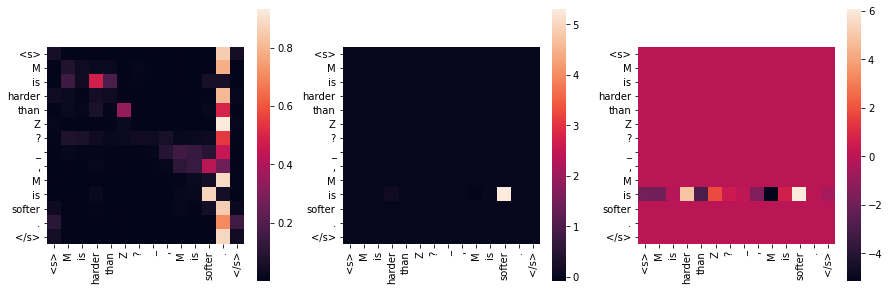

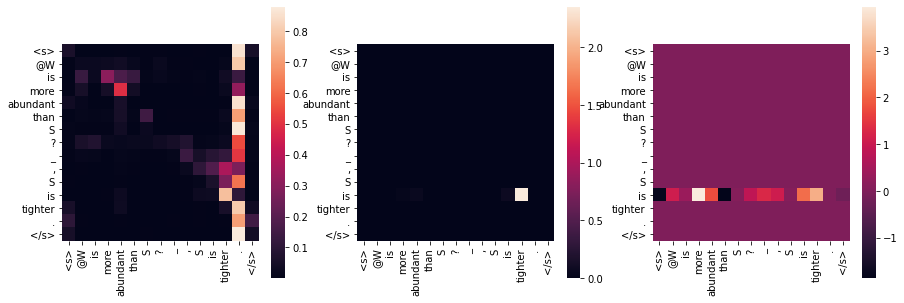

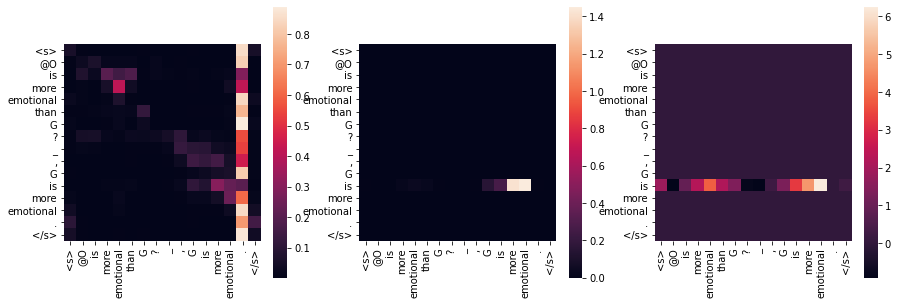

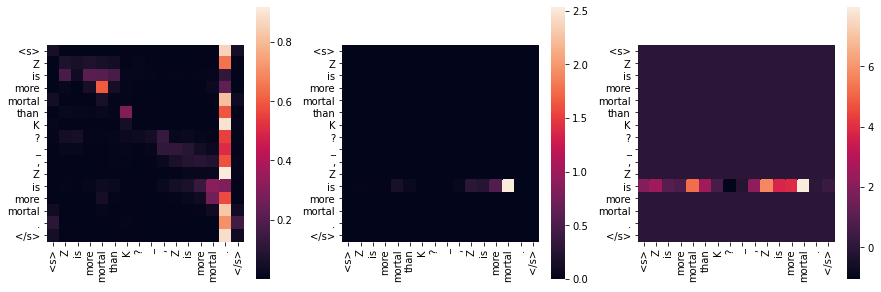

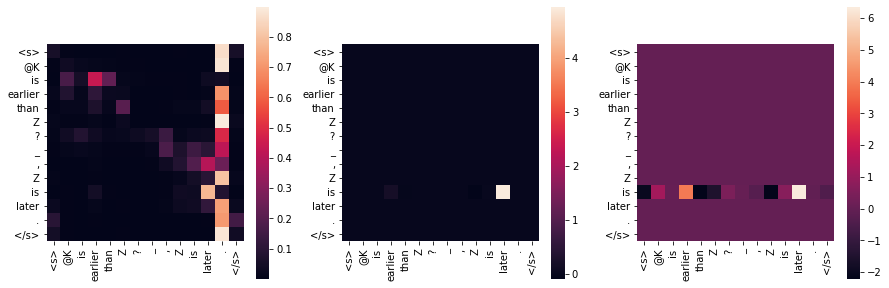

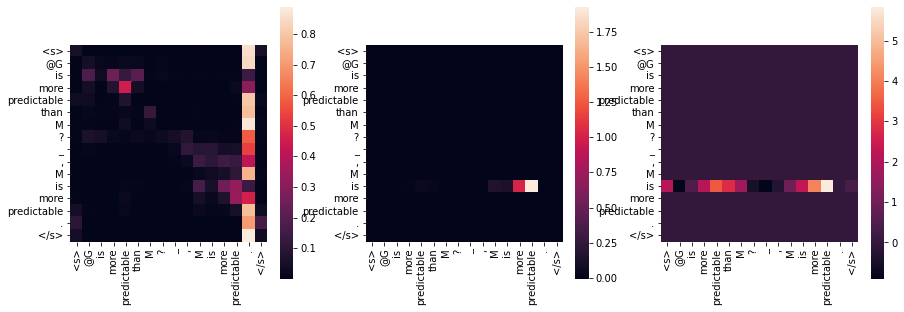

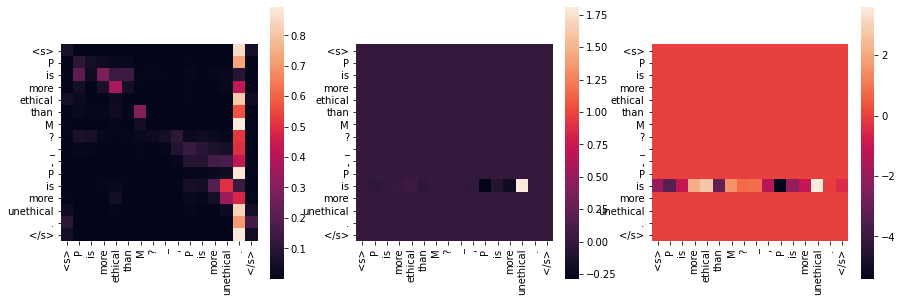

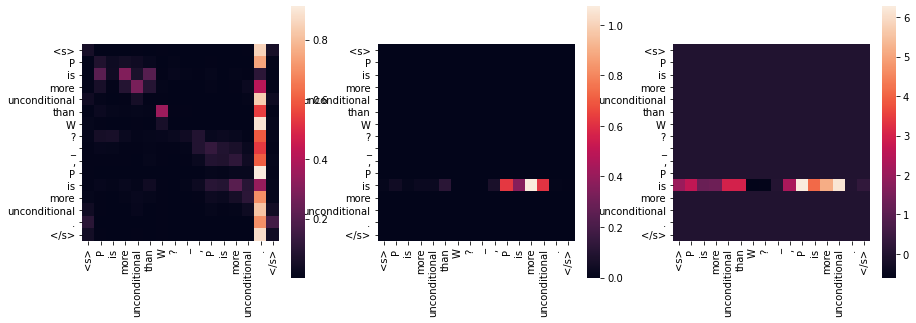

In [158]:
for i in range(len(attns)):
    seq_len = inputs['attention_mask'][i].sum().item()
    attn =  attns[i, head, : seq_len, : seq_len]
    grad = grads[i, head, : seq_len, : seq_len]
    tokens = normalize_tokens(tokenizer.convert_ids_to_tokens(inputs['input_ids'][i])[: seq_len])
    size = round(attn.size(0) / 3)
    fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(size * 3., size))#, gridspec_kw={'width_ratios': [3, 1]})
    _ = sns.heatmap(attn.detach().cpu(), square=True, cbar=True, annot=False, fmt='d', xticklabels=tokens, yticklabels=tokens, ax=ax0)
    _ = sns.heatmap((attn * grad).detach().cpu(), square=True, cbar=True, annot=False, xticklabels=tokens, yticklabels=tokens, ax=ax1)
    _ = sns.heatmap(grad.detach().cpu(), square=True, cbar=True, annot=False, xticklabels=tokens, yticklabels=tokens, ax=ax2)

In [227]:
_ = model.eval()
model.zero_grad()
# with torch.no_grad():
_, logits, probe_logits, all_attentions = model(**inputs, output_attentions=True, detach=False)[:4]
attn_probs = all_attentions  # torch.stack(all_attentions, dim=0).cpu()

In [228]:
base_layer, layer = 6, 6
H, bsz = 12, probe_logits.size(0)
tc_labels = inputs['tc_labels'][inputs['tc_labels'] != -100]
so_token_id, mask_token_id = tokenizer._convert_token_to_id('Ġso'), tokenizer.mask_token_id
pos = (inputs['input_ids'] == so_token_id).nonzero()[:, 1].item()
tokens = normalize_tokens(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0]))
attn_probs[layer].retain_grad()
probe_logits[torch.arange(bsz), (layer - base_layer) * H: (layer - base_layer + 1) * H, tc_labels].mean().backward()

0.8664488792419434

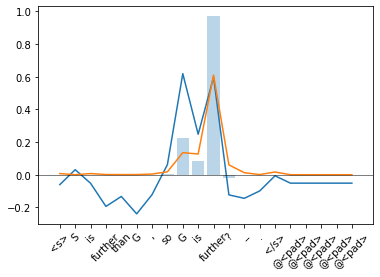

In [229]:
head = 6
ga = attn_probs[layer].grad[:, head][0, pos]
a = attn_probs[layer][:, head][0, pos]
nn.Softmax(dim=-1)(probe_logits)[torch.arange(bsz), (layer - base_layer) * H + head, tc_labels].item()

_ = plt.plot(normalize(ga.cpu()))
_ = plt.plot(a.detach().cpu())
_ = plt.bar(range(len(tokens)), normalize((ga * a.detach()).cpu()), alpha=0.3)
_ = plt.axhline(y=0, linewidth=0.5, color='k')
_ = plt.xticks(range(len(tokens)), tokens, rotation=45)

0.5935156941413879

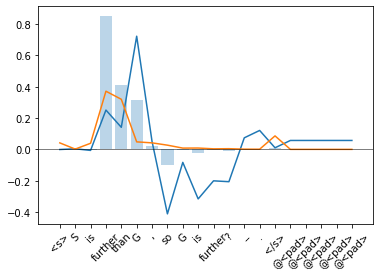

In [220]:
head = 10
ga = attn_probs[layer].grad[:, head][0, pos]
a = attn_probs[layer][:, head][0, pos]
nn.Softmax(dim=-1)(probe_logits)[torch.arange(bsz), (layer - base_layer) * H + head, tc_labels].item()

_ = plt.plot(normalize(ga.cpu()))
_ = plt.plot(a.detach().cpu())
_ = plt.bar(range(len(tokens)), normalize((ga * a.detach()).cpu()), alpha=0.3)
_ = plt.axhline(y=0, linewidth=0.5, color='k')
_ = plt.xticks(range(len(tokens)), tokens, rotation=45)

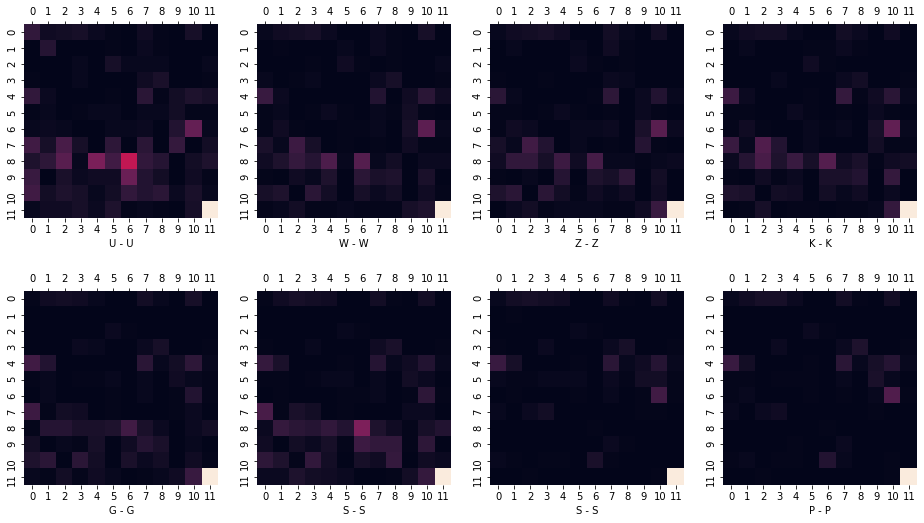

In [406]:
sample_indices = [[0, 1, 2, 3], 
                  [4, 5, 6, 7]]
# sample_indices = [[0, 0], 
#                   [0, 0]]
n_rows, n_cols = len(sample_indices), len(sample_indices[0])
fig, axs = plt.subplots(n_rows, n_cols, sharey=False, figsize=(4 * n_cols, 4.5 * n_rows))
sep_id = tokenizer._convert_token_to_id('Ġ,')
for row in range(n_rows):
    for col in range(n_cols):
        i, ax = sample_indices[row][col], axs[row][col]
        tokens = normalize_tokens(tokenizer.convert_ids_to_tokens(inputs['input_ids'][i]))
        
        p, h = inputs['marked_pos_labels'][i][0]
        p, h = p.item(), h.item()
        so_pos = (inputs['input_ids'][i] == tokenizer._convert_token_to_id('Ġso')).nonzero()[0, 0].item()
        be2_pos = so_pos + 2
        mask_pos = (inputs['input_ids'][i] == tokenizer.mask_token_id).nonzero()[0, 0].item()
#         j = 17
        pos_attn = attn_probs[:, i, :, mask_pos, h]
        pos_attn[-1, -1] = 1.
        ax = sns.heatmap((pos_attn * 100).long(), square=True, cbar=False, annot=False, fmt='d', ax=ax)
        ax.tick_params(top=True, labeltop=True)
        _ = ax.set_xlabel('%s - %s' % (tokens[p], tokens[h]))

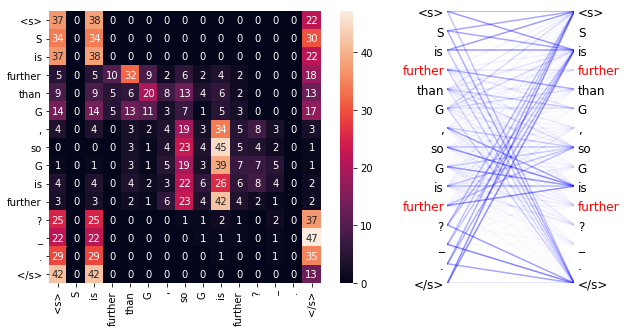

In [209]:
i = 0
layer, head = 7, 10
seq_len = inputs['attention_mask'][i].sum().item()
attn =  attn_probs[layer][i, head, : seq_len, : seq_len]
tokens = normalize_tokens(tokenizer.convert_ids_to_tokens(inputs['input_ids'][i])[: seq_len])
size = round(attn.size(0) / 3)
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(size  * 2., size), gridspec_kw={'width_ratios': [3, 1]})
_ = sns.heatmap((attn * 100).long().cpu(), square=True, cbar=True, annot=True, fmt='d', xticklabels=tokens, yticklabels=tokens, ax=ax0)
plot_head_attn(attn, tokens, ax1=ax1, marked_positions=inputs['marked_pos_labels'][i])

H5-8, H6-4, H7-6(+1), H7-10: ,/so/is/more -> h_ent  
H8-6: ?/mask -> so

H6-6: ,/so/is/more -> h  
H6-10: ,/so/is/more -> p  
H7-9: ?/mask -> so

In [ ]:
#         pos_attn = attn_probs[:, i]
#         pos_attn = pos_attn * (pos_attn > 0.3)
# #         pos_attn[0] = 0  # layer 0
# #         pos_attn[1, 1] = 0  # ->pos-2
#         pos_attn = pos_attn.mean(dim=(0, 1))
#         input_ids = inputs['input_ids'][i]
#         sep_pos = (input_ids == sep_id).nonzero()[0].item()
#         segment_ids = torch.zeros_like(input_ids)
#         segment_ids[sep_pos + 1:] = 1
#         segment_mask = segment_ids.unsqueeze(0) != segment_ids.unsqueeze(1)
#         pos_attn = pos_attn * segment_mask.cpu()
#         seq_len = inputs['attention_mask'][i].sum().item()
#         pos_attn[:, [0, 2, seq_len - 1]] = 0
#         k = torch.arange(1, pos_attn.size(0) - 1)
#         pos_attn[k, k] = 0
#         pos_attn[k, k - 1] = 0
#         pos_attn[k, k + 1] = 0
#         ax = sns.heatmap((pos_attn * 100).long(), square=True, cbar=False, annot=False, fmt='d', 
#                          xticklabels=tokens, yticklabels=tokens, ax=ax)

In [231]:
length = 4
range_vec = torch.arange(length)
range_mat = range_vec.unsqueeze(-1).expand(-1, length).transpose(0, 1)
distance_mat = range_mat - range_mat.transpose(0, 1)

In [232]:
range_vec

tensor([0, 1, 2, 3])

In [233]:
range_mat

tensor([[0, 1, 2, 3],
        [0, 1, 2, 3],
        [0, 1, 2, 3],
        [0, 1, 2, 3]])

In [234]:
distance_mat

tensor([[ 0,  1,  2,  3],
        [-1,  0,  1,  2],
        [-2, -1,  0,  1],
        [-3, -2, -1,  0]])

In [238]:
max_relative_positions = 2

In [239]:
distance_mat_clipped = torch.clamp(distance_mat,
                                   min=-max_relative_positions,
                                   max=max_relative_positions)

In [240]:
distance_mat_clipped

tensor([[ 0,  1,  2,  2],
        [-1,  0,  1,  2],
        [-2, -1,  0,  1],
        [-2, -2, -1,  0]])

In [241]:
final_mat = distance_mat_clipped + max_relative_positions

In [242]:
final_mat

tensor([[2, 3, 4, 4],
        [1, 2, 3, 4],
        [0, 1, 2, 3],
        [0, 0, 1, 2]])

In [243]:
torch.arange(-length + 1, 1, 1).unsqueeze(0)

tensor([[-3, -2, -1,  0]])